### Домашнее задание: "Детекция объектов на изображении"

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt

import os
import sys
import json

import numpy as np
import torch
from torch import nn
from torchvision.transforms.functional import to_tensor, normalize

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is:", device)


Device is: cuda


Скачиваем и распаковываем датасет

In [ ]:
!gdown "https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF" -O seminar_objdet_retina_oi5_ball.zip

Downloading...
From (original): https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF
From (redirected): https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF&confirm=t&uuid=62dbf68c-a8cb-48ee-8bda-bf3fd4950c10
To: /content/seminar_objdet_retina_oi5_ball.zip
100% 1.08G/1.08G [00:09<00:00, 119MB/s]


In [ ]:
!unzip seminar_objdet_retina_oi5_ball.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/2688.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._2688.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/1381.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._1381.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0921.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._0921.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0909.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._0909.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/3025.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._3025.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/1626.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._1626.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0538.jpg  
  inflating: __MACOSX/seminar_objd

## 0.Выбор модели
Для решения задачи детекции была выбрана SSD модель, предобученная на датасете
Выбор обусловлен тем, что SSD быстрая обностадийная модель.

In [ ]:
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights

weights = SSD300_VGG16_Weights.COCO_V1  # или DEFAULT
model = ssd300_vgg16(weights=weights)
model.eval()

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

Прогоним на тестовой картинке

In [ ]:
# 2. Подготовка картинки
img_path = "seminar_objdet_retina_oi5_ball/oi5_ball/0006.jpg"
img = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.ToTensor(),
])
img_tensor = transform(img).unsqueeze(0)  # добавляем батч [1, C, H, W]

In [ ]:
# 3. Инференс
with torch.no_grad():
    predictions = model(img_tensor)  # список словарей, 1 элемент на изображение


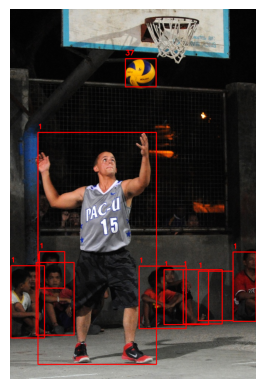

In [ ]:
# 4. Визуализация bbox
pred = predictions[0]
img_cv = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

for box, label, score in zip(pred['boxes'], pred['labels'], pred['scores']):
    if score > 0.2:  # порог уверенности
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img_cv, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img_cv, str(label.item()), (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

plt.imshow(img_cv)
plt.axis('off')
plt.show()

Видим что предобученная SSD детектирует разные классы, так что нам нужно заменить только голову

## 1. Подготовка обучающего набора данных

Класс датасета в файле ball.dataset.py
Основной особенностью SSD является то, что она не может принимать изображения любого размера, так что масштабируем до 300x300

+ Добавляем простые и сложные аугментации

In [61]:
from ball_dataset import DetectionDataset

img_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.5)
])

train_dataset = DetectionDataset("seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json", img_transforms)
val_dataset = DetectionDataset("seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json")


In [62]:
import random

simple_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Сложная аугментация: горизонтальный флип с пересчётом боксов
def random_horizontal_flip(img, boxes, p=0.5):
    if random.random() < p:
        img = transforms.functional.hflip(img)
        w, h = img.size
        boxes[:, [0, 2]] = w - boxes[:, [2, 0]]
    return img, boxes

# В Dataset можно передать:
train_dataset = DetectionDataset(
    "seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json",
    transform=simple_transforms, #аугментации
    augment_bbox=random_horizontal_flip
)

val_dataset = DetectionDataset(
    "seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json"
)

In [63]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    return tuple(zip(*batch))

# создаем даталоудеры
data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=1,
    collate_fn=collate_fn, drop_last=True)

data_loader_val = torch.utils.data.DataLoader(
    val_dataset, batch_size=2, shuffle=False, num_workers=1,
    collate_fn=collate_fn, drop_last=False)

## 2. Дообучение *модели*

In [64]:
import torch
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights


# загружаем SSD с предобученными весами COCO
model = ssd300_vgg16(weights=SSD300_VGG16_Weights.COCO_V1)

# переводим на устройство
model.to(device)


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [85]:
from torchvision.models.detection.ssd import SSDClassificationHead
import torch.optim as optim

# --- 1. заменяем голову на 2 класса (шар + фон) ---
num_classes = 2  # 1 класс шар + фон

# стандартные anchor-ы для SSD300_VGG16
num_anchors = [4, 6, 6, 6, 4, 4]

# получаем список in_channels с текущей головы
in_channels = [m.in_channels for m in model.head.classification_head.module_list]

# создаём новую голову
model.head.classification_head = SSDClassificationHead(
    in_channels, num_anchors, num_classes
)

model.head.to(device)

# --- 2. оптимизатор ---
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=5e-4)


In [87]:
# --- 3. тренировочный цикл ---
model.train()
num_epochs = 10  # можно увеличить позже
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, targets in data_loader:
        # перемещаем на устройство
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # forward pass + loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # backward
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(data_loader):.4f}")


Epoch 1/10, Loss: 2.3282
Epoch 2/10, Loss: 2.2033
Epoch 3/10, Loss: 2.0666
Epoch 4/10, Loss: 2.0137
Epoch 5/10, Loss: 1.9392
Epoch 6/10, Loss: 1.8295
Epoch 7/10, Loss: 1.7377
Epoch 8/10, Loss: 1.7593
Epoch 9/10, Loss: 1.8769
Epoch 10/10, Loss: 1.6584


## 3. Валидация на map
Для модели, обучаемой не очень долго, вполне неплохо

In [116]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# создаём метрику
metric = MeanAveragePrecision(iou_thresholds=[0.5])

model.eval()
with torch.no_grad():
    for images, targets in data_loader_val:
        images = [img.to(device) for img in images]
        preds = model(images)

        # переводим всё на CPU, чтобы отдать в метрику
        preds = [{k: v.cpu() for k, v in p.items()} for p in preds]
        targets = [{k: v.cpu() for k, v in t.items()} for t in targets]

        # обновляем метрику
        metric.update(preds, targets)

# вычисляем финальные результаты
results = metric.compute()

print("📊 Оценка на валидации:")
print(f"mAP@[0.5:0.95]: {results['map']:.4f}")
print(f"mAP (small): {results['map_small']:.4f}")
print(f"mAP (medium): {results['map_medium']:.4f}")
print(f"mAP (large): {results['map_large']:.4f}")


📊 Оценка на валидации:
mAP@[0.5:0.95]: 0.5679
mAP (small): 0.4463
mAP (medium): 0.6575
mAP (large): 0.7358


## 4. Выводы

Посмотрим что на картинках показывают

In [108]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_ssd_prediction(img_tensor, prediction, thresh=0.3):
    """
    img_tensor: тензор изображения из Dataset (C,H,W)
    prediction: вывод модели SSD ([dict] с ключами 'boxes', 'scores', 'labels')
    thresh: минимальная уверенность для показа боксов
    """
    # преобразуем в HWC и numpy
    img = img_tensor.permute(1,2,0).cpu().numpy()
    img = (img * 255).astype(np.uint8)

    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # предсказанные боксы
    boxes = prediction[0]['boxes'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()

    for i, score in enumerate(scores):
        if score < thresh:
            continue
        box = boxes[i].astype(int)
        cv2.rectangle(img_bgr, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)
        cv2.putText(img_bgr, f"Ball {score:.2f}", (box[0], box[1]-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    # показать
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def visualize_ssd_batch(model, dataset, indices, device, thresh=0.3):
    """
    Использует твою функцию visualize_ssd_prediction для нескольких картинок.
    """
    model.eval()
    with torch.no_grad():
        for idx in indices:
            img, target = dataset[idx]
            prediction = model([img.to(device)])

            print(f"🔹 Image index: {idx}")
            visualize_ssd_prediction(img, prediction, thresh=thresh)


Проверяем на одной картинке

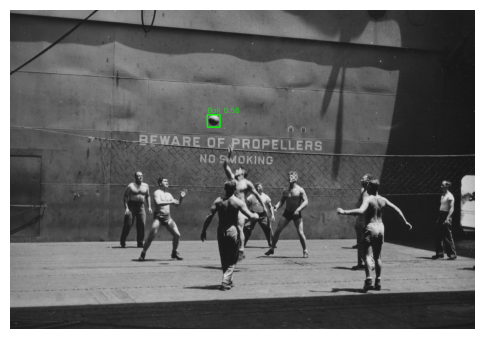

In [107]:
# берем изображение и таргет из валидационного датасета
img, target = val_dataset[0]

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

visualize_ssd_prediction(img, prediction, thresh=0.3)


И еще картинок

Выбраны индексы: [166, 217, 5, 38, 53, 75]
🔹 Image index: 166


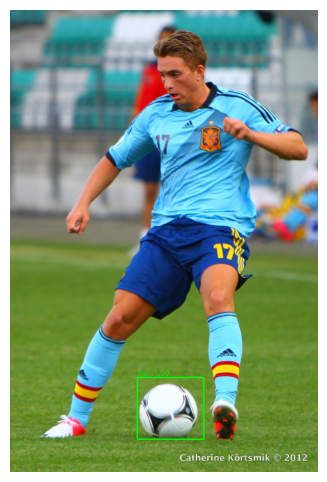

🔹 Image index: 217


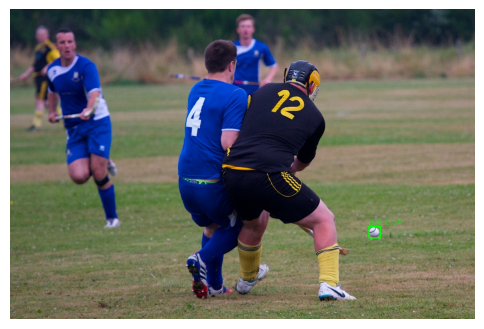

🔹 Image index: 5


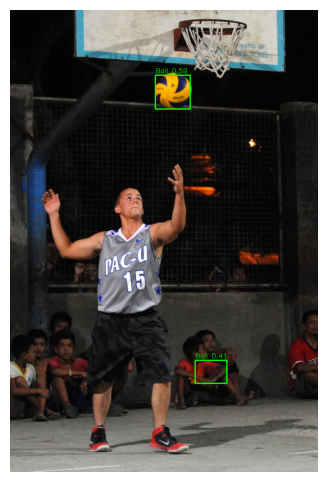

🔹 Image index: 38


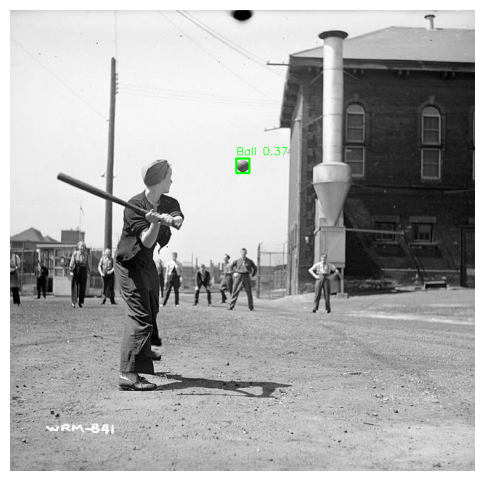

🔹 Image index: 53


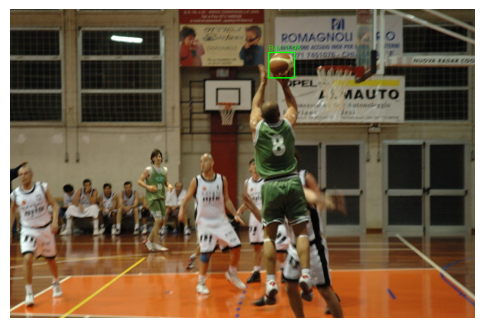

🔹 Image index: 75


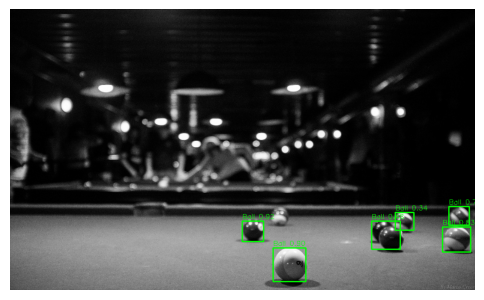

In [119]:
import random

# выберем случайно 3 изображения из валидационного датасета
random_indices = random.sample(range(len(val_dataset)), 6)
print("Выбраны индексы:", random_indices)

visualize_ssd_batch(model, val_dataset, random_indices, device, thresh=0.2)


Выводы:
На cpu ничего не обучается, в google colab обучается, но медленно, поэтому домашки надо делать заранее